## Setup

In [307]:
from datetime import datetime, timedelta
from pathlib import Path
import re

import astropy.units as u
from astropy.coordinates import SkyCoord
from IPython.display import clear_output, display
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from reproject import reproject_interp
import requests
from scipy import ndimage as ndi
import sunpy.map
from sunpy.coordinates import HeliographicCarrington, frames
from sunpy.map import all_coordinates_from_map
from sunpy.visualization import colormaps as cm

In [308]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [309]:
from Library.CH import *
from Library.Config import *
from Library.IO import *
from Library.Model import *
from Library.Plot import *
from Library.Processing import *

from Models import load_date_range

## Data & Model

In [310]:
df = pd.read_parquet(paths["artifact_root"] + "Paths.parquet")

ARCH_ID = "A2"
DATE_ID = "D2"

date_range = load_date_range(ARCH_ID, DATE_ID)
train_df, val_df = date_range.select_pairs(df)

if val_df is None:
    inf_df = df.loc[~df.index.isin(train_df.index)]
else:
    combined_df = pd.concat([train_df, val_df])
    inf_df = df.loc[~df.index.isin(combined_df.index)]

model = load_trained_model(ARCH_ID, DATE_ID)
print(
    f"train: {len(train_df)}  val: {len(val_df) if val_df is not None else 0}  inf: {len(inf_df)}"
)

/Users/aosh/Developer/helio-n/Outputs/Models/A2D2.keras


/opt/homebrew/Caskroom/miniconda/base/envs/icme3.12-metal/lib/python3.12/site-packages/keras/src/trainers/trainer.py:212: UserWarning: Model doesn't support `jit_compile=True`. Proceeding with `jit_compile=False`.
  warnings.warn(


train: 5240  val: 580  inf: 14346


In [311]:
# Pick a sample row (with HMI data)
df_valid = df.dropna(subset=["hmi_path"])
row = df_valid.iloc[200]
print(row.name, row.fits_path)

20100702_1752 /Volumes/Aux Disk/mnt~sun/FITS/2010/07/02/AIA20100702_1752_0193.fits


## HMI

### `load_observation` — load AIA 193, AIA 304, HMI and reproject

In [312]:
def load_observation(row):
    """
    Load AIA 193 Å, (optional) AIA 304 Å, and HMI magnetogram.
    HMI is reprojected onto the AIA 193 pixel grid.

    Returns
    -------
    dict with keys:
        aia       : 2-D array (normalised AIA 193 image)
        aia_map   : sunpy Map of AIA 193
        hmi       : 2-D float32 array (reprojected HMI, NaN→0)
        aia304    : 2-D array or None
        has_304   : bool
    """
    _, aia = prepare_fits(row.fits_path)
    aia_map = sunpy.map.Map(row.fits_path)
    hmi_map = sunpy.map.Map(row.hmi_path)

    hmi_reprojected, _ = reproject_interp(hmi_map, aia_map.wcs, shape_out=aia.shape)
    hmi = np.flipud(hmi_reprojected.astype(np.float32))
    hmi = np.nan_to_num(hmi, nan=0.0)

    has_304 = hasattr(row, "aia304_path") and pd.notna(row.aia304_path)
    aia304 = None
    if has_304:
        try:
            _, aia304 = prepare_fits(row.aia304_path)
        except Exception:
            has_304 = False

    return {
        "aia": aia,
        "aia_map": aia_map,
        "hmi": hmi,
        "aia304": aia304,
        "has_304": has_304,
    }

### `compute_heliocentric_angles` — θ and cos θ maps from WCS

In [313]:
def compute_heliocentric_angles(aia_map):
    """
    Compute heliocentric angle θ (degrees) and cos(θ) for every pixel.

    Returns
    -------
    theta_deg : 2-D array (flipped to match imshow orientation)
    cos_theta : 2-D array
    """
    coords = all_coordinates_from_map(aia_map)
    hpc = coords.transform_to(
        frames.Helioprojective(observer=aia_map.observer_coordinate)
    )
    rho_deg = np.sqrt(hpc.Tx.to(u.deg).value ** 2 + hpc.Ty.to(u.deg).value ** 2)
    r_sun_deg = float(aia_map.rsun_obs.to(u.deg).value)
    sin_theta = np.clip(rho_deg / r_sun_deg, 0, 1)
    theta_rad = np.arcsin(sin_theta)
    theta_deg = np.flipud(np.degrees(theta_rad))
    cos_theta = np.flipud(np.cos(theta_rad))
    return theta_deg, cos_theta

### `apply_angle_correction` — unified cutoff + B_los → B_r

In [314]:
def apply_angle_correction(
    hmi, theta_deg, cos_theta, angle_correction=True, mask_over_60=False
):
    """
    Apply unified angle cutoff and optional B_los → B_r correction.

    Cutoff logic:
      mask_over_60 ON  → 60° (cos ≥ 0.5)
      mask_over_60 OFF + angle_correction ON → 80° (implicit limb safety)
      both OFF → no cutoff

    Returns
    -------
    hmi_corrected : 2-D float32 (zeroed outside safe zone when correcting)
    angle_mask    : 2-D bool (True = inside safe zone)
    angle_cutoff  : float or None
    """
    if mask_over_60:
        angle_cutoff = 60.0
    elif angle_correction:
        angle_cutoff = 80.0
    else:
        angle_cutoff = None

    angle_mask = np.ones_like(hmi, dtype=bool)
    if angle_cutoff is not None:
        angle_mask = theta_deg <= angle_cutoff

    hmi_out = hmi.copy()
    if angle_correction:
        hmi_out = np.where(angle_mask, hmi_out / cos_theta, 0.0).astype(np.float32)

    return hmi_out, angle_mask, angle_cutoff

### `compute_elongation` — region elongation from second moments

In [315]:
def compute_elongation(binary_mask):
    """
    Compute elongation of a binary region from its second central moments.

    Elongation = 1 - (minor_axis / major_axis).
    0 = perfectly circular, approaching 1 = very elongated.

    Uses eigenvalues of the 2×2 inertia tensor to find principal axes.

    Parameters
    ----------
    binary_mask : 2-D bool array

    Returns
    -------
    float  (0–1)
    """
    ys, xs = np.where(binary_mask)
    if len(ys) < 2:
        return 0.0

    cy, cx = ys.mean(), xs.mean()
    dy, dx = ys - cy, xs - cx

    # 2×2 covariance / inertia tensor
    Ixx = np.mean(dx * dx)
    Iyy = np.mean(dy * dy)
    Ixy = np.mean(dx * dy)

    # Eigenvalues → principal axes lengths (proportional to sqrt(eigenvalue))
    T = Ixx + Iyy
    D = Ixx * Iyy - Ixy * Ixy
    disc = max(T * T / 4 - D, 0.0)
    lam1 = T / 2 + np.sqrt(disc)
    lam2 = T / 2 - np.sqrt(disc)

    major = np.sqrt(max(lam1, 0.0))
    minor = np.sqrt(max(lam2, 0.0))

    if major == 0:
        return 0.0
    return float(1.0 - minor / major)

### `extract_hole_data` — per-component statistics

In [316]:
def extract_hole_data(labeled, n_holes, hmi_data):
    """
    For each labelled connected component, extract HMI values
    and summary statistics including elongation.

    Returns list of dicts, one per hole.
    """
    holes = []
    for hole_id in range(1, n_holes + 1):
        hole_mask = labeled == hole_id
        hmi_values = hmi_data[hole_mask]
        centroid = ndi.center_of_mass(hole_mask)
        elongation = compute_elongation(hole_mask)
        holes.append(
            {
                "label": hole_id,
                "hmi_values": hmi_values,
                "area_px": int(hole_mask.sum()),
                "centroid": centroid,
                "mean_hmi": float(hmi_values.mean()),
                "std_hmi": float(hmi_values.std()),
                "elongation": elongation,
            }
        )
    return holes

### `label_coronal_holes` — mask, label, extract per-hole data

In [317]:
def label_coronal_holes(row, model, hmi, angle_mask, smoothing_params=None):
    """
    Obtain U-Net and IDL binary masks, apply angle mask, then label
    connected components and extract per-hole HMI statistics.

    Returns
    -------
    dict with keys:
        nn_labeled, nn_n_holes, nn_holes,
        idl_labeled, idl_n_holes, idl_holes
    """
    if smoothing_params is None:
        smoothing_params = get_postprocessing_params("P1")

    pmap = find_or_make_pmap(row, model)
    nn_mask = (pmap_to_mask(pmap, smoothing_params) > 0.5) & angle_mask

    idl_mask = (prepare_mask(row.mask_path) > 0.5) & angle_mask

    nn_labeled, nn_n_holes = ndi.label(nn_mask)
    idl_labeled, idl_n_holes = ndi.label(idl_mask)

    nn_holes = extract_hole_data(nn_labeled, nn_n_holes, hmi)
    idl_holes = extract_hole_data(idl_labeled, idl_n_holes, hmi)

    return {
        "nn_labeled": nn_labeled,
        "nn_n_holes": nn_n_holes,
        "nn_holes": nn_holes,
        "idl_labeled": idl_labeled,
        "idl_n_holes": idl_n_holes,
        "idl_holes": idl_holes,
    }

### `compute_stats` — mean, skewness, flux ratio

In [318]:
def compute_stats(values):
    """
    Compute summary statistics for a 1-D array of HMI values.

    Returns dict with keys: mean, skew, flux_ratio.
    """
    values = np.asarray(values)
    if values.size == 0:
        return {"mean": np.nan, "skew": np.nan, "flux_ratio": np.nan}

    mean_val = float(values.mean())
    std_val = float(values.std())
    if std_val == 0.0 or values.size < 3:
        skew_val = np.nan
    else:
        centered = values - mean_val
        skew_val = float(np.mean(centered**3) / (std_val**3))

    abs_sum = float(np.sum(np.abs(values)))
    flux_ratio = float(np.abs(np.sum(values)) / abs_sum) if abs_sum != 0.0 else np.nan
    return {"mean": mean_val, "skew": skew_val, "flux_ratio": flux_ratio}

### `plot_multiband` — 2- or 3-panel image display

In [319]:
def plot_multiband(
    aia,
    hmi,
    nn_labeled,
    nn_holes,
    aia304=None,
    has_304=False,
    corr_label="B_los",
    mask_label="",
    aia_map=None,
    filaments_df=None,
):
    """
    Show AIA 193, (optional) AIA 304, and HMI side-by-side
    with polarity contours overlaid.
    """
    hmi_norm = np.clip(hmi, -1000, 1000)
    hmi_norm = (hmi_norm + 1000) / 2000

    n_images = 3 if has_304 else 2
    fig = plt.figure(figsize=(5 * n_images, 5))

    # --- AIA 193 ---
    ax = fig.add_subplot(1, n_images, 1)
    ax.imshow(aia, cmap=cm.cmlist.get("sdoaia193"))
    _overlay_contours(ax, nn_labeled, nn_holes, show_labels=True)
    if filaments_df is not None and aia_map is not None:
        _overlay_filaments(ax, aia_map, filaments_df, color="lime")
    ax.set_title(f"AIA 193 Å | {len(nn_holes)} holes (U-Net)")
    ax.axis("off")

    # --- AIA 304 ---
    if has_304 and aia304 is not None:
        ax = fig.add_subplot(1, n_images, 2)
        ax.imshow(aia304, cmap=cm.cmlist.get("sdoaia304"))
        _overlay_contours(ax, nn_labeled, nn_holes)
        if filaments_df is not None and aia_map is not None:
            _overlay_filaments(ax, aia_map, filaments_df, color="lime")
        ax.set_title("AIA 304 Å")
        ax.axis("off")

    # --- HMI ---
    ax = fig.add_subplot(1, n_images, n_images)
    ax.imshow(hmi_norm, cmap=cm.cmlist["hmimag"])
    _overlay_contours(ax, nn_labeled, nn_holes)
    if filaments_df is not None and aia_map is not None:
        _overlay_filaments(ax, aia_map, filaments_df, color="lime")
    ax.set_title(f"HMI ({corr_label}){mask_label}")
    ax.axis("off")

    plt.tight_layout()
    plt.show()


def _overlay_contours(ax, labeled, holes, show_labels=False):
    """Draw red/blue polarity contours (and optional hole-ID labels)."""
    for hole in holes:
        mask = (labeled == hole["label"]).astype(float)
        color = "red" if hole["mean_hmi"] >= 0 else "blue"
        ax.contour(mask, levels=[0.5], colors=color, linewidths=2)
        if show_labels:
            cy, cx = hole["centroid"]
            ax.text(
                cx,
                cy,
                str(hole["label"]),
                fontsize=12,
                color="white",
                ha="center",
                va="center",
                weight="bold",
                bbox=dict(boxstyle="circle", facecolor="orange", alpha=0.7),
            )


def _overlay_filaments(ax, aia_map, filaments_df, color="lime", lw=1.5, alpha=0.9):
    """Draw Kislovodsk filament segments on the given axes.

    world_to_pixel returns FITS-convention y (row 0 = south).
    The displayed data has been np.flipud'd (row 0 = north) and is
    shown with origin='upper', so we convert:  y_disp = (Ny-1) - y_fits.
    """
    if filaments_df is None or aia_map is None or len(filaments_df) == 0:
        return 0

    Ny = aia_map.data.shape[0]

    try:
        observer = aia_map.observer_coordinate
    except Exception:
        observer = "earth"
    obstime = aia_map.date

    n_plotted = 0
    for _, fil in filaments_df.iterrows():
        try:
            frame = HeliographicCarrington(observer=observer, obstime=obstime)
            c1 = SkyCoord(lon=fil.lon1 * u.deg, lat=fil.lat1 * u.deg, frame=frame)
            c2 = SkyCoord(lon=fil.lon2 * u.deg, lat=fil.lat2 * u.deg, frame=frame)
            px1 = aia_map.world_to_pixel(c1)
            px2 = aia_map.world_to_pixel(c2)
            # Convert FITS y → display y (flipud convention)
            y1 = (Ny - 1) - px1.y.value
            y2 = (Ny - 1) - px2.y.value
            ax.plot(
                [px1.x.value, px2.x.value],
                [y1, y2],
                color=color,
                lw=lw,
                alpha=alpha,
            )
            n_plotted += 1
        except Exception:
            continue

    return n_plotted

### `plot_hole_histograms` — per-hole B-field distributions

In [320]:
def plot_hole_histograms(holes, B_thresh=8):
    """
    Plot a grid of histograms, one per coronal hole.
    Values below ±B_thresh are excluded.
    """
    n = len(holes)
    if n == 0:
        print("No holes to plot.")
        return

    n_cols = 2
    n_rows = max(1, (n + n_cols - 1) // n_cols)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4 * n_rows))
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    axes = axes.flatten()

    for idx, hole in enumerate(holes):
        ax = axes[idx]
        vals_raw = hole["hmi_values"]
        if len(vals_raw) == 0:
            ax.text(
                0.5, 0.5, "No data", ha="center", va="center", transform=ax.transAxes
            )
            ax.set_title(f"Hole #{hole['label']}")
            continue

        vals = vals_raw[np.abs(vals_raw) >= B_thresh]
        if len(vals) == 0:
            ax.text(
                0.5,
                0.5,
                "No data after threshold",
                ha="center",
                va="center",
                transform=ax.transAxes,
            )
            ax.set_title(f"Hole #{hole['label']}")
            continue

        stats = compute_stats(vals)
        mean_val = stats["mean"]
        color = "red" if mean_val >= 0 else "blue"

        lo = np.floor(vals.min() / 2) * 2 - 1
        hi = np.ceil(vals.max() / 2) * 2 + 1
        bins = np.arange(lo, hi + 2, 2)

        ax.hist(vals, bins=bins, color=color, alpha=0.7, edgecolor="black")
        ax.set_xlim(-50, 50)
        ax.set_xlabel("HMI [Gauss]")
        ax.set_ylabel("Count")
        ax.set_yscale("log")
        ax.set_title(f"Hole #{hole['label']}: n={len(vals)}px, mean={mean_val:.1f}")
        ax.grid(alpha=0.3)

    for idx in range(n, len(axes)):
        axes[idx].set_visible(False)

    plt.tight_layout()
    plt.show()

### `print_stats_table` — console statistics summary

In [321]:
def print_stats_table(nn_holes, B_thresh=8, corr_label="B_los", mask_label=""):
    """
    Print a formatted table of per-hole statistics
    (raw and thresholded) for U-Net masks, including elongation.
    """
    hdr = f"[{corr_label}{mask_label}]"
    W = 150

    print(f"\n{'=' * W}")
    print(f"{'U-Net (helio-n) Holes  ' + hdr:^{W}}")
    print(f"{'-' * W}")
    print(
        f"{'Hole#':<6} {'Area(px)':<10} {'N px':<8} "
        f"{'Elong':<8} "
        f"{'Mean':<10} {'Skew':<10} {'|Σ|/Σ||':<14} "
        f"{'Mean_T':<10} {'Skew_T':<10} {'|Σ|/Σ||_T':<16}"
    )
    print(f"{'-' * W}")
    for hole in nn_holes:
        raw = hole["hmi_values"]
        thr = raw[np.abs(raw) >= B_thresh]
        sr = compute_stats(raw)
        st = compute_stats(thr)
        elong = hole.get("elongation", np.nan)
        elong_str = f"{elong:.2f}" if not np.isnan(elong) else "N/A"
        print(
            f"{hole['label']:<6} {hole['area_px']:<10} {len(raw):<8} "
            f"{elong_str:<8} "
            f"{sr['mean']:<10.2f} {sr['skew']:<10.2f} {sr['flux_ratio']:<14.3f} "
            f"{st['mean']:<10.2f} {st['skew']:<10.2f} {st['flux_ratio']:<16.3f}"
        )
    print(f"{'=' * W}\n")

## 304A

### AIA 304 — brightness analysis (subfunctions)
Utility functions for computing disk mean and per-hole 304 Å statistics.

In [322]:
def compute_304_disk_brightness(aia304):
    """Compute mean 304 Å brightness across the full disk (no angle mask).
    Returns NaN if aia304 is None or contains no finite pixels.
    """
    if aia304 is None:
        return np.nan
    vals = np.asarray(aia304)
    vals = vals[np.isfinite(vals)]
    if vals.size == 0:
        return np.nan
    return float(np.mean(vals))

In [323]:
def extract_304_hole_stats(aia304, labeled, n_holes):
    """Extract per-hole 304 Å brightness stats (mean + dark-skew).
    Returns list of dicts with keys: label, brightness_mean, brightness_dark_skew, n_pixels
    """
    if aia304 is None:
        return []
    holes = []
    for hole_id in range(1, n_holes + 1):
        hole_mask = labeled == hole_id
        if not hole_mask.any():
            holes.append(
                {
                    "label": hole_id,
                    "brightness_mean": np.nan,
                    "brightness_dark_skew": np.nan,
                    "n_pixels": 0,
                }
            )
            continue
        brightness_vals = aia304[hole_mask]
        mean_br = float(np.mean(brightness_vals))
        inverted = 1.0 - brightness_vals
        if len(inverted) > 2:
            std_inv = float(np.std(inverted))
            if std_inv > 0:
                centered = inverted - np.mean(inverted)
                dark_skew = float(np.mean(centered**3) / (std_inv**3))
            else:
                dark_skew = np.nan
        else:
            dark_skew = np.nan
        holes.append(
            {
                "label": hole_id,
                "brightness_mean": mean_br,
                "brightness_dark_skew": dark_skew,
                "n_pixels": int(hole_mask.sum()),
            }
        )
    return holes

In [324]:
def plot_304_brightness_analysis(aia304, labeled, n_holes, disk_brightness=None):
    """
    Plot 304 Å brightness analysis: disk mean, per-hole histograms, bar chart.
    """
    if aia304 is None:
        print("AIA 304 not available.")
        return

    if disk_brightness is None:
        disk_brightness = compute_304_disk_brightness(aia304)
    hole_stats = extract_304_hole_stats(aia304, labeled, n_holes)
    if not hole_stats:
        print("No holes found.")
        return

    n_holes_valid = len(hole_stats)
    fig = plt.figure(figsize=(14, 4 * max(1, (n_holes_valid + 1) // 2)))
    n_cols = 2
    n_rows = max(1, (n_holes_valid + n_cols - 1) // n_cols)

    for idx, h in enumerate(hole_stats):
        ax = plt.subplot(n_rows, n_cols, idx + 1)
        hole_mask = labeled == h["label"]
        brightness_vals = aia304[hole_mask]
        if len(brightness_vals) > 0:
            ax.hist(
                brightness_vals, bins=30, color="orange", alpha=0.7, edgecolor="black"
            )
            ax.axvline(
                h["brightness_mean"],
                color="red",
                linestyle="--",
                linewidth=2,
                label=f"Mean: {h['brightness_mean']:.3f}",
            )
            ax.axvline(
                disk_brightness,
                color="black",
                linestyle="--",
                linewidth=2,
                label=f"Disk: {disk_brightness:.3f}",
            )
            ax.set_xlabel("304 Å Brightness")
            ax.set_ylabel("Count")
            skew_label = (
                f"{h['brightness_dark_skew']:.2f}"
                if not np.isnan(h["brightness_dark_skew"])
                else "N/A"
            )
            ax.set_title(f"Hole #{h['label']}: Dark Skew = {skew_label}")
            ax.legend(fontsize=9)
            ax.grid(alpha=0.3)

    if n_holes_valid % 2 == 1:
        ax = plt.subplot(n_rows, n_cols, n_holes_valid + 1)
        ax.axis("off")
    plt.tight_layout()
    plt.show()

    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    hole_ids = [h["label"] for h in hole_stats]
    brightness_means = [h["brightness_mean"] for h in hole_stats]
    colors_bright = ["red" if b > disk_brightness else "blue" for b in brightness_means]
    ax.bar(
        hole_ids, brightness_means, color=colors_bright, alpha=0.7, edgecolor="black"
    )
    ax.axhline(
        disk_brightness,
        color="black",
        linestyle="--",
        linewidth=2,
        label=f"Disk avg: {disk_brightness:.3f}",
    )
    ax.set_xlabel("Hole ID")
    ax.set_ylabel("Mean 304 Å Brightness")
    ax.set_title("Per-Hole 304 Å Brightness (red=brighter, blue=darker than disk)")
    ax.legend()
    ax.grid(alpha=0.3, axis="y")

    plt.tight_layout()
    plt.show()

## Kislovodsk Filaments


### `load_kislovodsk_filaments`
Download and parse filament segments from the [Kislovodsk Mountain Station catalog](http://93.180.26.198:8000/web/fillaments/) for a given observation date.

In [ ]:
def parse_kislovodsk_catalog(text):
    """Parse Kislovodsk catalog text into a DataFrame."""

    def _parse_float(val):
        s = str(val).strip().replace(",", ".")
        while s and s[0] not in "-0123456789.":
            s = s[1:]
        while s and s[-1] not in "0123456789":
            s = s[:-1]
        if s in {"", ".", "-", "-.", None}:
            raise ValueError("empty numeric")
        return float(s)

    rows = []
    for line in text.splitlines():
        parts = line.split()
        if len(parts) not in (7, 8):
            continue
        # Detect format: YYYYMM DD ... (2012+) vs YYYY MM DD ... (pre-2012)
        first_col = parts[0].strip()
        if len(first_col) == 6 and first_col.isdigit():
            # New format (2012+): YYYYMM DD lat1 lon1 lat2 lon2 brightness
            ym = int(first_col)
            y, m = ym // 100, ym % 100
            day_frac = _parse_float(parts[1])
            day_int = int(day_frac)
            frac = day_frac - day_int
            dt = datetime(y, m, day_int) + timedelta(days=frac)
            rows.append(
                {
                    "year": y,
                    "month": m,
                    "day_frac": day_frac,
                    "datetime": dt,
                    "lat1": _parse_float(parts[2]),
                    "lon1": _parse_float(parts[3]),
                    "lat2": _parse_float(parts[4]),
                    "lon2": _parse_float(parts[5]),
                    "brightness": int(_parse_float(parts[6])),
                }
            )
        else:
            # Old format (pre-2012): YYYY MM DD lat1 lon1 lat2 lon2 brightness
            y, m = int(parts[0]), int(parts[1])
            day_frac = _parse_float(parts[2])
            day_int = int(day_frac)
            frac = day_frac - day_int
            dt = datetime(y, m, day_int) + timedelta(days=frac)
            rows.append(
                {
                    "year": y,
                    "month": m,
                    "day_frac": day_frac,
                    "datetime": dt,
                    "lat1": _parse_float(parts[3]),
                    "lon1": _parse_float(parts[4]),
                    "lat2": _parse_float(parts[5]),
                    "lon2": _parse_float(parts[6]),
                    "brightness": int(_parse_float(parts[7])),
                }
            )

    columns = [
        "year",
        "month",
        "day_frac",
        "datetime",
        "lat1",
        "lon1",
        "lat2",
        "lon2",
        "brightness",
    ]
    return pd.DataFrame(rows, columns=columns)


def download_kislovodsk_catalog(save_path=None, start_year=1996, end_year=None):
    """Download Kislovodsk yearly files and save merged CSV."""
    base_url = "http://93.180.26.198:8000/web/fillaments/"
    if save_path is None:
        save_path = Path("Data") / "Kislovodsk Filaments.csv"
    if end_year is None:
        end_year = datetime.utcnow().year

    index_text = requests.get(base_url, timeout=30).text
    years = sorted(
        {int(y) for y in re.findall(r"(19\d{2}|20\d{2})_FL\.txt", index_text)}
    )
    years = [y for y in years if start_year <= y <= end_year]

    frames = []
    for year in years:
        url = f"{base_url}{year}_FL.txt"
        response = requests.get(url, timeout=30)
        if response.status_code == 404:
            continue
        response.raise_for_status()
        frames.append(parse_kislovodsk_catalog(response.text))

    if frames:
        df_all = pd.concat(frames, ignore_index=True)
    else:
        df_all = parse_kislovodsk_catalog("")

    save_path.parent.mkdir(parents=True, exist_ok=True)
    df_all.to_csv(save_path, index=False)
    return df_all


def load_kislovodsk_catalog(csv_path=None, start_year=1996, end_year=None):
    """Load merged Kislovodsk catalog from CSV (download if missing)."""
    if csv_path is None:
        csv_path = Path("Data") / "Kislovodsk Filaments.csv"
    if not csv_path.exists():
        return download_kislovodsk_catalog(
            csv_path, start_year=start_year, end_year=end_year
        )
    return pd.read_csv(csv_path, parse_dates=["datetime"])


def load_kislovodsk_filaments(obs_date, delta_days=1):
    """
    Return catalog segments within ±delta_days of the observation date.
    """
    if isinstance(obs_date, str):
        if "_" in obs_date and len(obs_date) >= 13:
            obs_date = datetime.strptime(obs_date[:13], "%Y%m%d_%H%M")
        else:
            obs_date = datetime.strptime(obs_date[:8], "%Y%m%d")

    global _kislovodsk_catalog
    if "_kislovodsk_catalog" not in globals() or _kislovodsk_catalog is None:
        _kislovodsk_catalog = load_kislovodsk_catalog()

    lo = obs_date - timedelta(days=delta_days)
    hi = obs_date + timedelta(days=delta_days)
    df_all = _kislovodsk_catalog
    return df_all[(df_all["datetime"] >= lo) & (df_all["datetime"] <= hi)].reset_index(
        drop=True
    )

In [326]:
download_kislovodsk_catalog()

/var/folders/3z/b4fclst96kbd90mb019v618m0000gn/T/ipykernel_34355/2724146096.py:61: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  end_year = datetime.utcnow().year
/var/folders/3z/b4fclst96kbd90mb019v618m0000gn/T/ipykernel_34355/2724146096.py:90: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_all = pd.concat(frames, ignore_index=True)


,year,month,day_frac,datetime,lat1,lon1,lat2,lon2,brightness
0,1996,1,1.33,1996-01-01 07:55:12,25.0,288.0,22.0,266.0,2
1,1996,1,1.33,1996-01-01 07:55:12,-44.0,287.0,-43.0,261.0,2
2,1996,1,1.33,1996-01-01 07:55:12,-2.0,267.0,-8.0,264.0,2
3,1996,1,1.33,1996-01-01 07:55:12,5.0,231.0,1.0,228.0,3
4,1996,1,1.33,1996-01-01 07:55:12,23.0,186.0,30.0,177.0,3
...,...,...,...,...,...,...,...,...,...
32259,2011,12,31.25,2011-12-31 06:00:00,10.0,91.0,17.0,83.0,2
32260,2011,12,31.25,2011-12-31 06:00:00,24.0,77.0,35.0,44.0,3
32261,2011,12,31.25,2011-12-31 06:00:00,-13.0,75.0,-19.0,62.0,2
32262,2011,12,31.25,2011-12-31 06:00:00,-29.0,56.0,-26.0,45.0,3


In [327]:
# --- demo: load_kislovodsk_filaments ---
filaments = load_kislovodsk_filaments(row.name)
print(f"Filaments within ±1 day of {row.name}: {len(filaments)} segments")
filaments.head(10)

Filaments within ±1 day of 20100702_1752: 26 segments


,year,month,day_frac,datetime,lat1,lon1,lat2,lon2,brightness
0,2010,7,2.13,2010-07-02 03:07:12,-34.0,221.0,-28.0,192.0,1
1,2010,7,2.13,2010-07-02 03:07:12,-57.0,206.0,-55.0,197.0,3
2,2010,7,2.13,2010-07-02 03:07:12,16.0,202.0,11.0,190.0,3
3,2010,7,2.13,2010-07-02 03:07:12,-58.0,190.0,-52.0,174.0,3
4,2010,7,2.13,2010-07-02 03:07:12,31.0,170.0,49.0,131.0,3
5,2010,7,2.13,2010-07-02 03:07:12,19.0,152.0,18.0,138.0,2
6,2010,7,2.13,2010-07-02 03:07:12,-14.0,148.0,-20.0,140.0,2
7,2010,7,2.13,2010-07-02 03:07:12,-17.0,128.0,-21.0,120.0,3
8,2010,7,2.13,2010-07-02 03:07:12,13.0,125.0,22.0,120.0,3
9,2010,7,2.13,2010-07-02 03:07:12,-24.0,119.0,-23.0,113.0,1


### `plot_filament_overlay`
Overlay Kislovodsk filament segments (yellow lines) and U-Net CH contours on an AIA 193 Å image.
Filament coordinates are Carrington heliographic; they are transformed to the map's pixel frame via SunPy.

In [328]:
def plot_filament_overlay(
    aia_map, nn_labeled, nn_holes, filaments_df, ax=None, figsize=(10, 10)
):
    """
    Overlay Kislovodsk filament line segments and CH contours on AIA 193.

    Uses aia_map.data (FITS convention) with origin='lower' so that
    world_to_pixel coords map directly.  nn_labeled must be flipped
    because the labelling pipeline works in display convention
    (row 0 = north, after flipud).

    Parameters
    ----------
    aia_map       : sunpy.map.Map – AIA 193 Å map (for WCS / observer info)
    nn_labeled    : 2-D int array – labelled CH mask from U-Net (display convention)
    nn_holes      : list of dicts – per-hole metadata (need 'mean_hmi' for colour)
    filaments_df  : pd.DataFrame – output of load_kislovodsk_filaments()
    ax            : optional matplotlib Axes
    figsize       : figure size when creating new figure
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    else:
        fig = ax.figure

    # AIA 193 background (log-stretch, FITS convention)
    aia_data = aia_map.data.astype(float)
    aia_data[aia_data <= 0] = 1
    ax.imshow(np.log1p(aia_data), origin="lower", cmap="sdoaia193")

    # CH contours — nn_labeled is in display convention (row 0 = north),
    # but the axes use origin='lower' (row 0 = south), so flip to match.
    nn_labeled_fits = np.flipud(nn_labeled)
    for h in nn_holes:
        hole_mask = nn_labeled_fits == h["label"]
        colour = "red" if h["mean_hmi"] > 0 else "blue"
        ax.contour(
            hole_mask.astype(float), levels=[0.5], colors=[colour], linewidths=1.2
        )

    # Filament segments (Carrington → pixel, FITS convention matches origin='lower')
    try:
        observer = aia_map.observer_coordinate
    except Exception:
        observer = "earth"
    obstime = aia_map.date

    n_plotted = 0
    for _, fil in filaments_df.iterrows():
        try:
            frame = HeliographicCarrington(observer=observer, obstime=obstime)
            c1 = SkyCoord(
                lon=fil.lon1 * u.deg,
                lat=fil.lat1 * u.deg,
                frame=frame,
            )
            c2 = SkyCoord(
                lon=fil.lon2 * u.deg,
                lat=fil.lat2 * u.deg,
                frame=frame,
            )
            px1 = aia_map.world_to_pixel(c1)
            px2 = aia_map.world_to_pixel(c2)
            ax.plot(
                [px1.x.value, px2.x.value],
                [px1.y.value, px2.y.value],
                color="lime",
                lw=1.5,
                alpha=0.85,
            )
            n_plotted += 1
        except Exception:
            continue  # off-disk or transform failure

    ax.set_title(
        f"AIA 193 + CH contours + Kislovodsk filaments "
        f"({n_plotted}/{len(filaments_df)} on-disk)",
        fontsize=11,
    )
    ax.set_xlabel("pixel")
    ax.set_ylabel("pixel")
    plt.tight_layout()
    plt.show()
    return fig

In [329]:
# --- demo: plot_filament_overlay ---
# Uses obs, ch, filaments already in scope from previous cells
row = df_valid.iloc[3334]
filaments = load_kislovodsk_filaments(row.name)
filaments

,year,month,day_frac,datetime,lat1,lon1,lat2,lon2,brightness


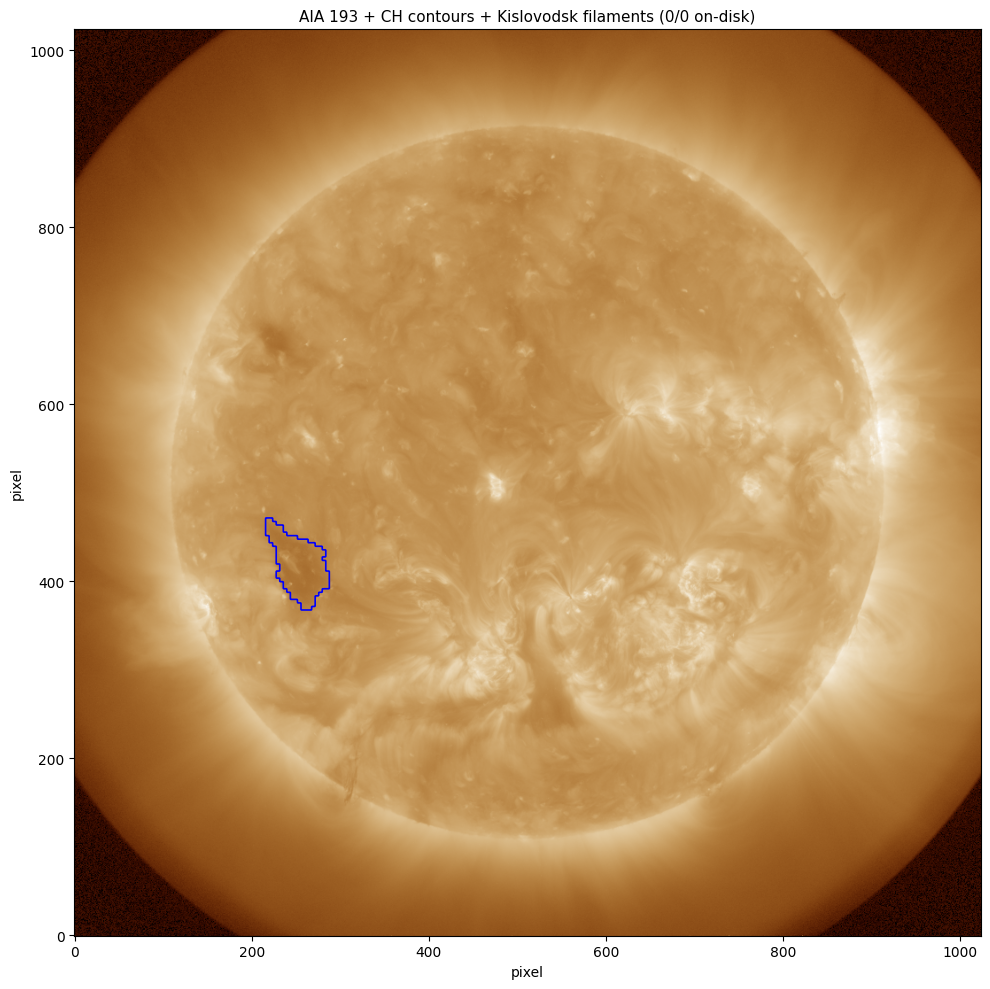

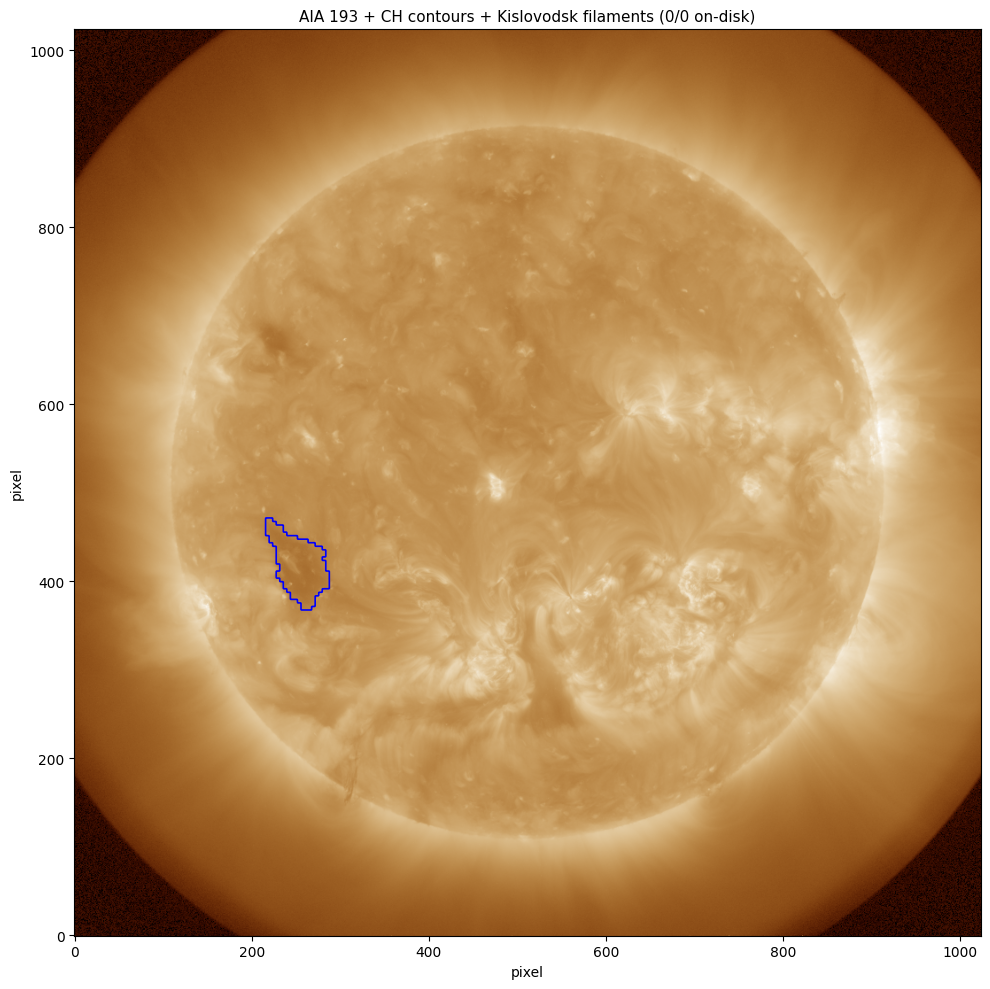

In [330]:
obs = load_observation(row)
theta_deg, cos_theta = compute_heliocentric_angles(obs["aia_map"])
hmi_corr, angle_mask, _ = apply_angle_correction(
    obs["hmi"],
    theta_deg,
    cos_theta,
    angle_correction=True,
    mask_over_60=False,
)
ch = label_coronal_holes(row, model, hmi_corr, angle_mask)

plot_filament_overlay(
    obs["aia_map"],
    ch["nn_labeled"],
    ch["nn_holes"],
    filaments,
)

## Huge Interactive Plot

In [331]:
def plot_with_polarity(
    row,
    model,
    B_thresh=8,
    smoothing_params=None,
    angle_correction=True,
    mask_over_60=False,
    filaments_df=None,
):
    """
    Full polarity analysis pipeline.

    1. Load observation (AIA 193, 304, HMI)
    2. Compute heliocentric angles
    3. Apply angle correction / cutoff
    4. Label coronal holes (U-Net)
    5. Plot multi-band images with contours
    6. Plot per-hole histograms (HMI)
    7. Plot 304 Å brightness analysis
    8. Print statistics table (with elongation)
    """
    obs = load_observation(row)
    theta_deg, cos_theta = compute_heliocentric_angles(obs["aia_map"])
    hmi_corr, angle_mask, angle_cutoff = apply_angle_correction(
        obs["hmi"],
        theta_deg,
        cos_theta,
        angle_correction=angle_correction,
        mask_over_60=mask_over_60,
    )

    ch = label_coronal_holes(
        row,
        model,
        hmi_corr,
        angle_mask,
        smoothing_params=smoothing_params,
    )

    if filaments_df is None:
        try:
            filaments_df = load_kislovodsk_filaments(row.name)
        except Exception as exc:
            print(f"Filament catalog unavailable: {exc}")
            filaments_df = None

    corr_label = "B_r (angle-corrected)" if angle_correction else "B_los (raw)"
    mask_label = f" | θ≤{angle_cutoff:.0f}°" if angle_cutoff is not None else ""

    plot_multiband(
        obs["aia"],
        hmi_corr,
        ch["nn_labeled"],
        ch["nn_holes"],
        aia304=obs["aia304"],
        has_304=obs["has_304"],
        corr_label=corr_label,
        mask_label=mask_label,
        aia_map=obs["aia_map"],
        filaments_df=filaments_df,
    )
    plot_hole_histograms(ch["nn_holes"], B_thresh=B_thresh)

    # 304 Å brightness analysis
    if obs["has_304"]:
        disk_brightness_304 = compute_304_disk_brightness(obs["aia304"])
        plot_304_brightness_analysis(
            obs["aia304"],
            ch["nn_labeled"],
            ch["nn_n_holes"],
            disk_brightness=disk_brightness_304,
        )

    print_stats_table(
        ch["nn_holes"],
        B_thresh=B_thresh,
        corr_label=corr_label,
        mask_label=mask_label,
    )

    return {
        **ch,
        **obs,
        "hmi_corrected": hmi_corr,
        "angle_mask": angle_mask,
    }

In [332]:
# Preserve state across re-runs
try:
    last_polarity_row_idx
except NameError:
    last_polarity_row_idx = 0

try:
    last_b_thresh
except NameError:
    last_b_thresh = 8

try:
    filament_cache
except NameError:
    filament_cache = {}

# Prepare dataframe with date labels
df_with_date = df.dropna(subset=["hmi_path"]).copy()
df_with_date["date"] = pd.to_datetime(
    df_with_date.index, format="%Y%m%d_%H%M"
).strftime("%Y-%m-%d %H:%M")

if last_polarity_row_idx >= len(df_with_date):
    last_polarity_row_idx = max(0, len(df_with_date) - 1)

# --- Widgets ---
full_row = widgets.Layout(width="100%")
checkbox_layout = widgets.Layout(margin="0 0 0 12px")

polarity_idx_slider = widgets.IntSlider(
    value=last_polarity_row_idx,
    min=0,
    max=max(0, len(df_with_date) - 1),
    step=1,
    description="Row:",
    continuous_update=False,
    layout=full_row,
)
b_thresh_slider = widgets.IntSlider(
    value=last_b_thresh,
    min=0,
    max=50,
    step=1,
    description="B thresh [G]:",
    continuous_update=False,
    layout=full_row,
)
angle_correction_checkbox = widgets.Checkbox(
    value=True,
    description="Angle correction (B_los → B_r)",
    layout=checkbox_layout,
)
mask_over_60_checkbox = widgets.Checkbox(
    value=False,
    description="Mask θ > 60°",
    layout=checkbox_layout,
)

polarity_out = widgets.Output()


def update_polarity_plot(change=None):
    global last_polarity_row_idx, last_b_thresh, filament_cache
    with polarity_out:
        clear_output(wait=True)
        if len(df_with_date) == 0:
            print("No valid data available")
            return

        row = df_with_date.iloc[polarity_idx_slider.value]
        date_str = row["date"]
        b_thresh = int(b_thresh_slider.value)

        polarity_idx_slider.description = f"{date_str}"
        polarity_idx_slider.style = {"description_width": "initial"}

        last_polarity_row_idx = polarity_idx_slider.value
        last_b_thresh = b_thresh

        print(f"\n{'=' * 100}")
        print(f"Date: {date_str:^96}|")
        print(f"Index: {row.name:^94}|")
        print(f"B_thresh: {b_thresh:^90}|")
        print(f"{'=' * 100}")
        print(f"FITS Path: {row.fits_path}")
        print(f"HMI Path:  {row.hmi_path}")
        print(f"Mask Path: {row.mask_path}")
        print(f"{'=' * 100}\n")

        filament_key = str(row.name)
        filaments_df = filament_cache.get(filament_key)
        if filaments_df is None or len(filaments_df) == 0:
            try:
                filaments_df = load_kislovodsk_filaments(filament_key)
            except Exception as exc:
                print(f"Filament catalog unavailable: {exc}")
                filaments_df = None
            filament_cache[filament_key] = filaments_df

        plot_with_polarity(
            row,
            model,
            B_thresh=b_thresh,
            angle_correction=angle_correction_checkbox.value,
            mask_over_60=mask_over_60_checkbox.value,
            filaments_df=filaments_df,
        )


for w in [
    polarity_idx_slider,
    b_thresh_slider,
    angle_correction_checkbox,
    mask_over_60_checkbox,
]:
    w.observe(update_polarity_plot, names="value")

polarity_controls = widgets.VBox(
    [
        widgets.HBox([polarity_idx_slider], layout=full_row),
        widgets.HBox([b_thresh_slider], layout=full_row),
        widgets.HBox(
            [angle_correction_checkbox, mask_over_60_checkbox], layout=full_row
        ),
        polarity_out,
    ],
    layout=full_row,
)

display(polarity_controls)
update_polarity_plot(None)